In [199]:
import pandas as pd
import numpy as np
import pickle as pkl

from functools import partial

In [202]:
with open('table.pkl', 'rb') as handle:
    table = pkl.load(handle)

### Book

In [2]:
books = pd.read_csv('books.csv', usecols=['action', 'side', 'price', 'size', 'ts']).set_index('ts')

In [155]:
bbo = books.groupby('ts').apply(lambda g: g.iloc[[49, 50], :]).reset_index(level=0).drop('ts', axis=1)

### Depth

In [147]:
def get_depth(d: int, g: pd.DataFrame):
    _g = g.iloc[list(range(49-d+1,49+d+1)), :]
    _g['level'] = list(range(d, 0, -1)) + list(range(1, d+1))
    return _g

In [148]:
pivots = 49
d = 5
depths = books.groupby('ts').apply(partial(get_depth, d)).reset_index(level=0).drop('ts', axis=1)

In [149]:
wide = depths.pivot_table(
    index="ts",
    columns=['side', 'level'],
    values=["price", "size"],
    sort=False)

wide.columns = [f"{metric}_{side}_{level}" for side, metric, level in wide.columns]
depths = wide

In [150]:
depths.to_csv('depths.csv')

In [151]:
depths.iloc[:1000, :10].diff(axis=1).mean()

ask_price_5       NaN
ask_price_4   -0.6023
ask_price_3   -0.5553
ask_price_2   -0.4427
ask_price_1   -0.5538
bid_price_1   -0.1013
bid_price_2   -0.5623
bid_price_3   -0.8397
bid_price_4   -0.9059
bid_price_5   -0.7060
dtype: float64

<Axes: >

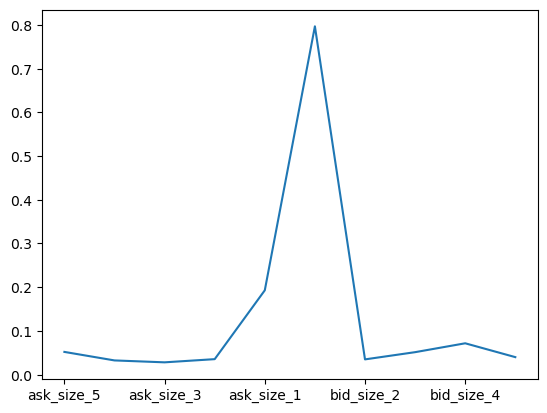

In [78]:
depths.iloc[:100, 10:].mean().plot()

In [152]:
accums = depths.copy()
for level in range(2, 5+1):
    for side in ['ask', 'bid']:
        pre = side+"_size_"+str(level-1)
        cur = side+"_size_"+str(level)
        accums[cur] += accums[pre]

<Axes: >

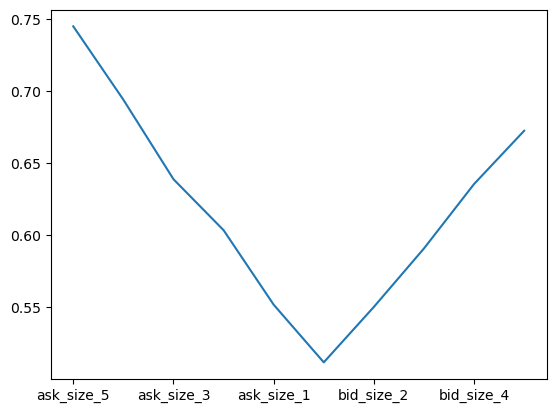

In [153]:
accums.iloc[:1000, 10:].mean().plot()

### BBO

In [156]:
wide = (
    bbo.pivot_table(
        index="ts",
        columns="side",
        values=["price", "size"],
        aggfunc="last"      # latest quote per ts/side if multiple rows
    )
)

# flatten MultiIndex columns -> price_ask, size_ask, price_bid, size_bid
wide.columns = [f"{metric}_{side}" for metric, side in wide.columns]
bbo = wide
bbo.head()

,price_ask,price_bid,size_ask,size_bid
ts,,,,
1762560000005,103335.4,103335.3,0.872284,0.301910
1762560000105,103335.4,103335.3,0.872284,0.312720
1762560000205,103335.4,103335.3,0.872284,0.312720
1762560000305,103335.4,103335.3,0.851870,0.312720
1762560000405,103335.4,103335.3,0.936217,0.312678


In [157]:
bbo.to_csv('bbo.csv')

In [160]:
spreads = bbo.price_ask - bbo.price_bid

In [163]:
spreads.to_csv('spreads.csv')

<Axes: >

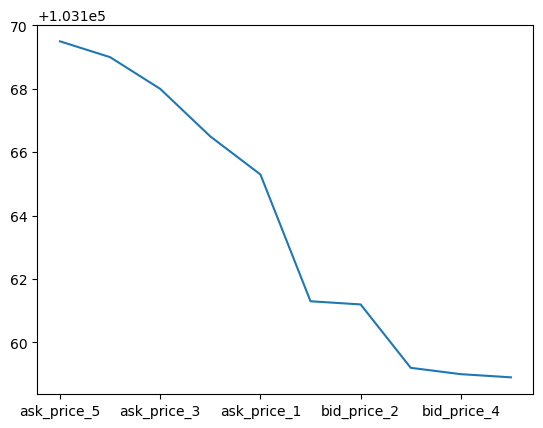

In [161]:
depths[spreads > 0.1 + 1e-8].iloc[5, :10].plot()

<Axes: xlabel='ts'>

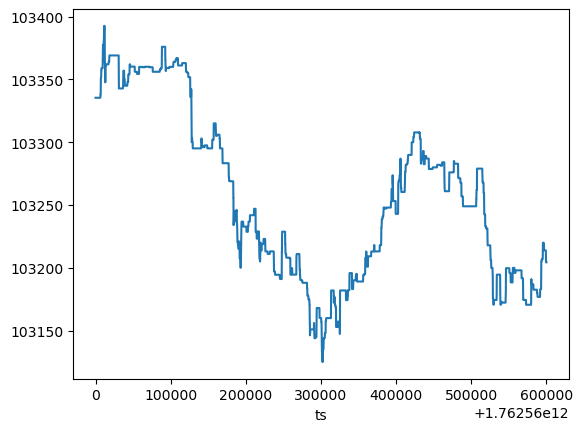

In [162]:
mid = ((bbo.price_ask + bbo.price_bid)/2)
mid.to_csv('mid.csv')
mid.plot()

In [166]:
norm = wide.size_ask + wide.size_bid
ar = wide.size_ask / norm
br = wide.size_bid / norm

In [167]:
wmid = (wide.price_ask * ar + wide.price_bid * br)

<Axes: xlabel='ts'>

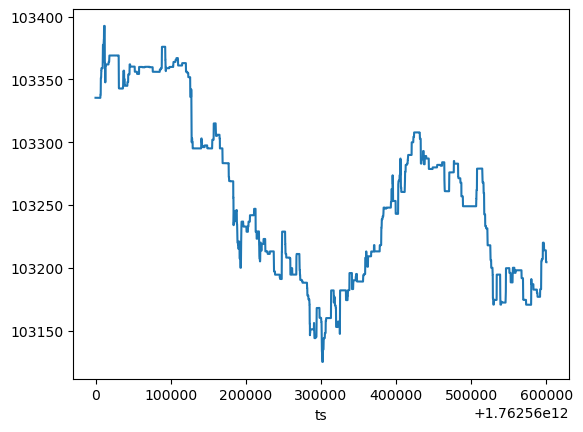

In [168]:
wmid.plot()

In [170]:
mid.describe()

count      6000.000000
mean     103256.567567
std          67.088741
min      103125.050000
25%      103195.850000
50%      103248.950000
75%      103300.050000
max      103392.550000
dtype: float64

### Returns

<Axes: xlabel='ts'>

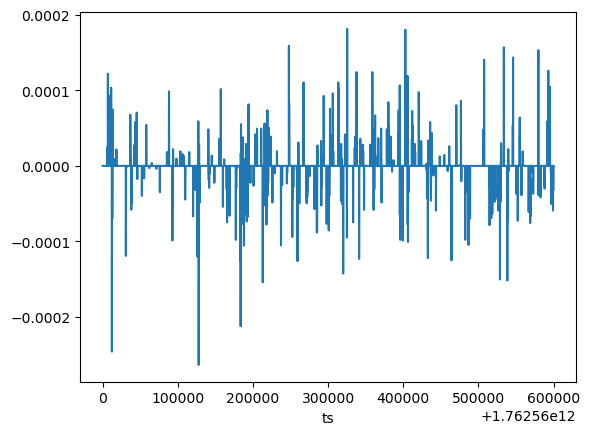

In [171]:
r = (mid - mid.shift(1))/mid
r = r.fillna(0)
r.plot()

In [172]:
rr = r[r!=0]

In [173]:
r[r==0].shape[0]/len(r)

0.9236666666666666

In [174]:
dt = pd.to_datetime(rr.index, unit='ms').to_series().diff().dt.total_seconds().fillna(0)

<Axes: >

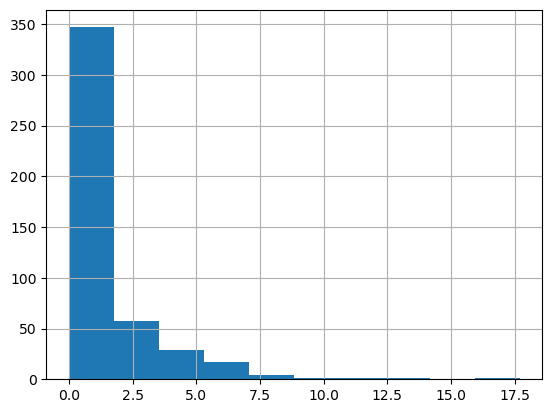

In [175]:
dt.hist()

In [176]:
print(dt.mean(), dt.std(), dt.skew(), dt.kurtosis())

1.2945414847161572 2.0351701705267105 2.966979179620369 13.159987843872191


In [177]:
c = []
s = 0
l = 0
l = r.iloc[0]
s = 1 if (l!=0) else 0
for t in r.iloc[1:]:
    if t != 0:
        s += 1
    else:
        c.append(s)
        s = 0
c = pd.Series(c)

<Axes: >

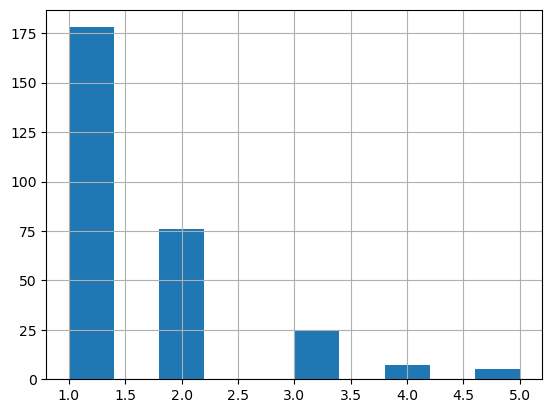

In [178]:
c[c!=0].hist()

In [179]:
sign = r.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)

<Axes: >

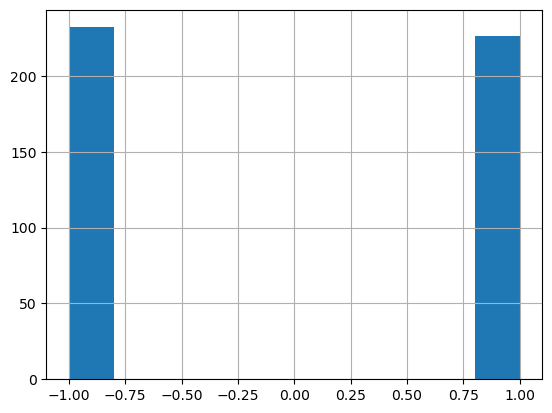

In [180]:
sign[sign!=0].hist()

In [181]:
ss = sign * sign.shift(1).fillna(0)

<Axes: >

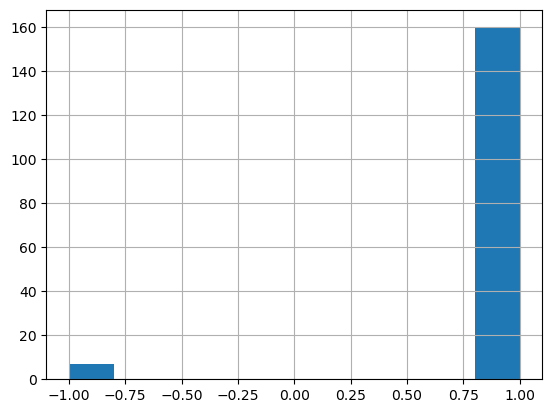

In [182]:
ss[ss!=0].hist()

In [183]:
print(r.skew(), r.kurtosis())

-1.2453023001543335 64.93617245596633


<Axes: >

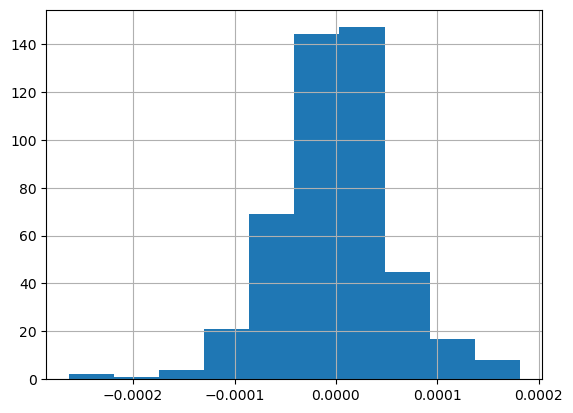

In [184]:
rr.hist()

In [185]:
print(rr.skew(), rr.kurtosis())

-0.21094975434092234 2.1912843342484254


In [186]:
np.corrcoef(r, r.shift(1).fillna(0))

array([[1.       , 0.1868102],
       [0.1868102, 1.       ]])

In [187]:
np.corrcoef(rr, rr.shift(1).fillna(0))

array([[1.        , 0.24176644],
       [0.24176644, 1.        ]])

### Table

In [200]:
table = {'depths': depths, 
         'bbo': bbo, 
         'mid': mid,
         'wmid': wmid,
         'r': r,
         'sign': sign,
         'ss': ss,
         }

In [201]:
with open('table.pkl', 'wb') as handle:
    pkl.dump(table, handle)